In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Constants import Const
import SymptomPreprocessing as Symptom
import re

In [4]:
%load_ext autoreload
%autoreload 2

In [55]:
# df = load_mdasi()
df = Symptom.load_mdasi()
df.head()

before drop count 823
after drop count 535


,is_ajcc_8th_edition,id,rt,performance_score,t_stage,concurrent,age,n_stage,hpv,ic,...,symptoms_work,symptoms_relations,symptoms_walking,symptoms_enjoy,t4,n3,BOT,Tonsil,old,digest_increase
0,False,1,1.0,0,t1,1.0,72.0,n2b,1.0,0.0,...,"[0.0, nan, nan, nan, nan, 0.0, 0.0, 10.0, 4.0,...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 1.0, 0.0, ...",0,0,1,0,1,0
6,False,7,1.0,1,t0,1.0,48.0,n2b,0.0,0.0,...,"[0.0, 0.0, 0.0, 1.0, 2.0, nan, 2.0, nan, 2.0, ...","[0.0, 2.0, 2.0, 1.0, 2.0, nan, 2.0, nan, 0.0, ...","[0.0, 0.0, 0.0, 2.0, 1.0, nan, 1.0, nan, 1.0, ...","[0.0, 0.0, 1.0, 2.0, 1.0, nan, 1.0, nan, 1.0, ...",0,0,0,0,0,0
7,False,8,1.0,0,t2,1.0,61.0,n2c,1.0,0.0,...,"[1.0, 1.0, nan, nan, nan, nan, nan, nan, 3.0, ...","[0.0, 1.0, nan, nan, nan, nan, nan, nan, 0.0, ...","[0.0, 0.0, nan, nan, nan, nan, nan, nan, 0.0, ...","[1.0, 1.0, nan, nan, nan, nan, nan, nan, 3.0, ...",0,1,1,0,1,0
8,False,9,1.0,0,t1,1.0,50.0,n2a,1.0,0.0,...,"[0.0, 0.0, nan, nan, 3.0, 3.0, 3.0, 2.0, 1.0, ...","[0.0, 0.0, nan, nan, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, nan, nan, 0.0, 0.0, 1.0, 2.0, 1.0, ...","[0.0, 1.0, nan, nan, 3.0, 2.0, 2.0, 3.0, 1.0, ...",0,0,0,1,0,0
9,-1,10,1.0,1,t4,1.0,70.0,n2b,1.0,1.0,...,"[0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 4.0, 4.0, 0.0, ...","[0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 3.0, 4.0, 1.0, ...","[0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 3.0, 2.0, 0.0, ...","[0.0, 1.0, 1.0, 2.0, 1.0, 3.0, 6.0, 3.0, 1.0, ...",1,0,1,0,1,0


In [7]:
#Dataset provided is a row for each organ, with ID, and dose information

In [76]:
base_df = pd.read_excel(Const.data_dir + 'Cohort_SMART2_530pts_(486pts).xlsx')
base_df.head()

,id,Structure,DicomType,Volume,mean,minGy,maxGy,V5,V10,V15,...,D65,D70,D75,D80,D85,D90,D95,D97,D98,D99
0,2.0,A_Carotid_Int_L,ORGAN,894.012451,67.978157,6079,7174,100,100,100,...,67.48,66.45,65.63,64.69,63.88,62.76,61.83,61.41,61.02,60.82
1,2.0,A_Carotid_Int_R,ORGAN,53.558350,58.114615,5708,5917,100,100,100,...,58.04,57.92,57.5,57.5,57.37,57.09,57.09,0.01,0.01,0.01
2,2.0,Bone_Hyoid,ORGAN,2101.135254,69.126667,5626,7282,100,100,100,...,68.33,67.79,67.41,66.67,65.82,64.58,62.16,60.3,59.82,58.32
3,2.0,Bone_Manubrium,ORGAN,36897.583008,30.844799,394,6735,96.237159,77.690933,69.305494,...,18.6,14.83,13.46,9.46,8.44,6.51,5.15,4.91,4.77,4.2
4,2.0,Bone_Mastoid_L,ORGAN,1557.312012,44.221032,1765,6038,100,100,100,...,41.74,39.99,38.44,36.03,33.2,29.16,23.8,22.44,20.77,18.41


In [71]:
#I map the names here to the original names in CAMPRT (originally for use with the spatial data, can be ignored if redone)
#The current code has a spellchecker, which is redundant with this list
organ_rename_dict  = {
    'cricoid': 'Cricoid_cartilage',
 'cricopharyngeus': 'Cricopharyngeal_Muscle',
 'esophagus_u': 'Esophagus',
 'oral_cavity': 'Extended_Oral_Cavity',
 'musc_geniogloss': 'Genioglossus_M',
 'hardpalate': 'Hard_Palate',
 'bone_hyoid': 'Hyoid_bone',
 'musc_constrict_i': 'IPC',
 'lips_lower': 'Lower_Lip',
 'lips_upper': 'Upper_Lip',
 'musc_constrict_m': 'MPC',
 'musc_mgh_complex': 'Mylogeniohyoid_M',
 'musc_mghcomplex': 'Mylogeniohyoid_M',
 'palate_soft': 'Soft_Palate',
 'musc_constrict_s': 'SPC',
 'spinalcord_cerv': 'Spinal_Cord',
 'larynx_sg': 'Supraglottic_Larynx',
 'cartlg_thyroid': 'Thyroid_cartilage',
 'brachial_plex_r': 'Rt_Brachial_Plexus',
 'brachial_plex_l': 'Lt_Brachial_Plexus',
 'pterygoid_lat_r': 'Rt_Lateral_Pterygoid_M',
 'pterygoid_lat_l': 'Lt_Lateral_Pterygoid_M',
 'musc_masseter_r': 'Rt_Masseter_M',
 'musc_masseter_l': 'Lt_Masseter_M',
 'bone_mastoid_r': 'Rt_Mastoid',
 'bone_mastoid_l': 'Lt_Mastoid',
 'pterygoid_med_r': 'Rt_Medial_Pterygoid_M',
 'pterygoid_med_l': 'Lt_Medial_Pterygoid_M',
 'parotid_r': 'Rt_Parotid_Gland',
 'parotid_l': 'Lt_Parotid_Gland',
 'musc_sclmast_r': 'Rt_Sternocleidomastoid_M',
 'musc_sclmast_l': 'Lt_Sternocleidomastoid_M',
 'glnd_submand_r': 'Rt_Submandibular_Gland',
 'glnd_submand_l': 'Lt_Submandibular_Gland',
 'musc_digastric_ra': 'Rt_Ant_Digastric_M',
 'musc_digastric_la': 'Lt_Ant_Digastric_M',
 'musc_digastric_rp': 'Rt_Post_Digastric_M',
 'musc_digastric_lp': 'Lt_Post_Digastric_M'
}

In [129]:
#rename headers to be consisent with CAMPRT Dataset
file_header_renames = {
        'mean': 'mean_dose',
        'Volume': 'volume',
        'minGy': 'min_dose',
        'maxGy': 'max_dose',
    }
df = base_df.rename(file_header_renames,axis=1)
df['ROI'] = df.Structure.apply(lambda x: organ_rename_dict.get(x.lower(),x))
df = df[df['DicomType'] =='ORGAN'].drop('DicomType',axis=1)
df.head()

,id,Structure,volume,mean_dose,min_dose,max_dose,V5,V10,V15,V20,...,D70,D75,D80,D85,D90,D95,D97,D98,D99,ROI
0,2.0,A_Carotid_Int_L,894.012451,67.978157,6079,7174,100,100,100,100,...,66.45,65.63,64.69,63.88,62.76,61.83,61.41,61.02,60.82,A_Carotid_Int_L
1,2.0,A_Carotid_Int_R,53.558350,58.114615,5708,5917,100,100,100,100,...,57.92,57.5,57.5,57.37,57.09,57.09,0.01,0.01,0.01,A_Carotid_Int_R
2,2.0,Bone_Hyoid,2101.135254,69.126667,5626,7282,100,100,100,100,...,67.79,67.41,66.67,65.82,64.58,62.16,60.3,59.82,58.32,Hyoid_bone
3,2.0,Bone_Manubrium,36897.583008,30.844799,394,6735,96.237159,77.690933,69.305494,62.907548,...,14.83,13.46,9.46,8.44,6.51,5.15,4.91,4.77,4.2,Bone_Manubrium
4,2.0,Bone_Mastoid_L,1557.312012,44.221032,1765,6038,100,100,100,98.941799,...,39.99,38.44,36.03,33.2,29.16,23.8,22.44,20.77,18.41,Lt_Mastoid


<Axes: >

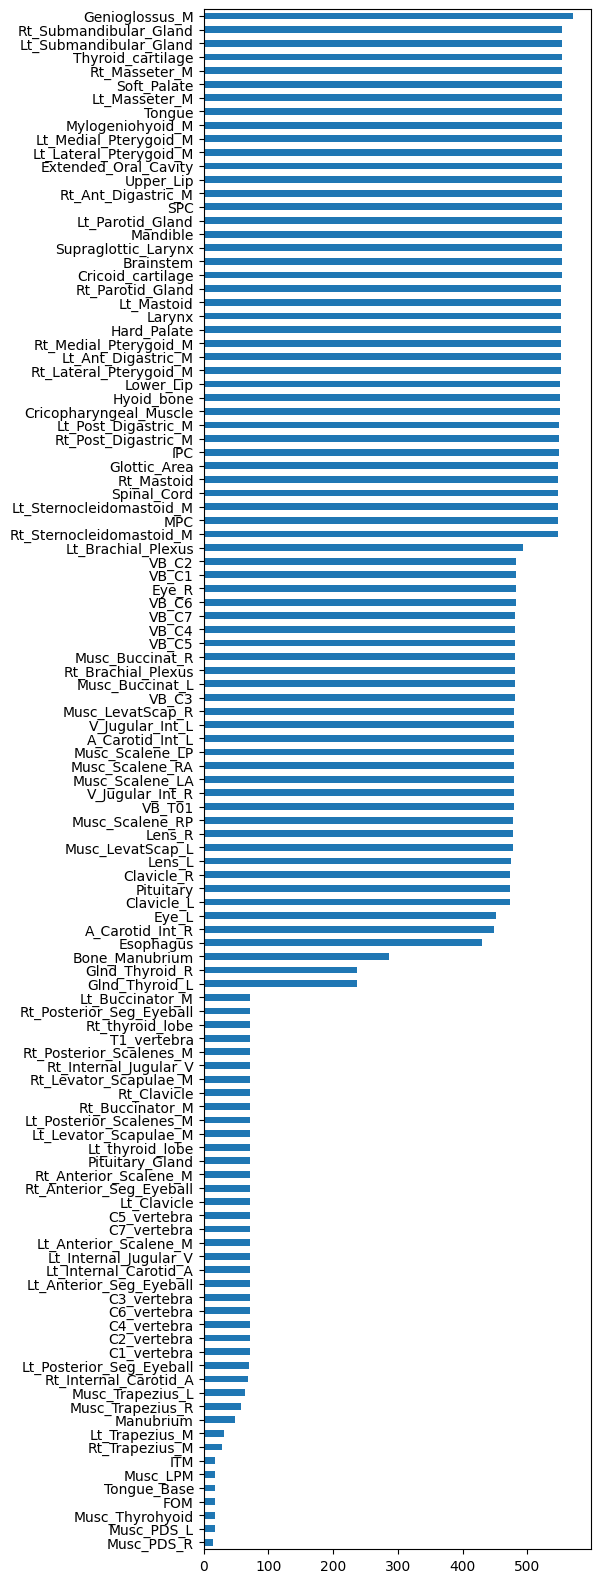

In [130]:
#The organ counts are variable. and have name inconsistencies. These will probably be different on a different dataset
organ_counts = {}
for _,row in df.iterrows():
    count = organ_counts.get(row['ROI'],0)
    organ_counts[row['ROI']] = count + 1
pd.Series(organ_counts).sort_values().plot(kind='barh',ax=plt.subplots(1,1,figsize=(5,20))[1])

In [131]:
#For reference, I use a static organ list that is the organs I select for and is also a fixed order for arrays of organ values
Const.organ_list

['Esophagus',
 'Spinal_Cord',
 'Lt_Brachial_Plexus',
 'Rt_Brachial_Plexus',
 'Cricopharyngeal_Muscle',
 'Cricoid_cartilage',
 'IPC',
 'MPC',
 'Brainstem',
 'Larynx',
 'Thyroid_cartilage',
 'Rt_Sternocleidomastoid_M',
 'Rt_Mastoid',
 'Rt_Parotid_Gland',
 'Rt_Medial_Pterygoid_M',
 'Rt_Lateral_Pterygoid_M',
 'Rt_Masseter_M',
 'Lt_Sternocleidomastoid_M',
 'Lt_Mastoid',
 'Lt_Parotid_Gland',
 'Lt_Submandibular_Gland',
 'Lt_Medial_Pterygoid_M',
 'Lt_Lateral_Pterygoid_M',
 'Lt_Masseter_M',
 'Supraglottic_Larynx',
 'SPC',
 'Rt_Submandibular_Gland',
 'Hyoid_bone',
 'Soft_Palate',
 'Genioglossus_M',
 'Tongue',
 'Rt_Ant_Digastric_M',
 'Lt_Ant_Digastric_M',
 'Mylogeniohyoid_M',
 'Extended_Oral_Cavity',
 'Mandible',
 'Hard_Palate',
 'Lower_Lip',
 'Upper_Lip',
 'Glottic_Area']

In [8]:
#In the dass code, the spellchecker was there to fix organ names and align them with the CAMPRT dataset, 
#which is what I was working on at the beginning of the project
#Furture projects will probably have a seperate thing.

In [147]:
#General Data Cleanup, may be required in future datasets
#enforce value columns to be numbers
def fix_df(df):
    df = df.drop_duplicates(subset=['id','ROI','volume'])
    df = df[df.mean_dose != 'error']
    #make sure volume and dose fields are actual numbers
    for col in df.columns:
        if 'dose' in col.lower() or 'volume' in col.lower():
            df[col] = df[col].astype(float)
    hist_cols = [c for c in df.columns if (re.match(r'[DV]\d+',c) is not None)]
    df[hist_cols] = df[hist_cols].astype('float16')
    df = df[~df.id.isna()]
    df['id'] = df.id.astype(int)
    return df
    

df = fix_df(df)
df.head()

/home/andrew/anaconda3/envs/dass/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/andrew/anaconda3/envs/dass/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,Structure,volume,mean_dose,min_dose,max_dose,V5,V10,V15,V20,...,D70,D75,D80,D85,D90,D95,D97,D98,D99,ROI
0,2,A_Carotid_Int_L,894.012451,67.978157,6079.0,7174.0,100.00,100.0000,100.0000,100.00000,...,66.437500,65.625000,64.687500,63.8750,62.750000,61.843750,61.406250,61.031250,60.812500,A_Carotid_Int_L
1,2,A_Carotid_Int_R,53.558350,58.114615,5708.0,5917.0,100.00,100.0000,100.0000,100.00000,...,57.906250,57.500000,57.500000,57.3750,57.093750,57.093750,0.010002,0.010002,0.010002,A_Carotid_Int_R
2,2,Bone_Hyoid,2101.135254,69.126667,5626.0,7282.0,100.00,100.0000,100.0000,100.00000,...,67.812500,67.437500,66.687500,65.8125,64.562500,62.156250,60.312500,59.812500,58.312500,Hyoid_bone
3,2,Bone_Manubrium,36897.583008,30.844799,394.0,6735.0,96.25,77.6875,69.3125,62.90625,...,14.828125,13.460938,9.460938,8.4375,6.511719,5.148438,4.910156,4.769531,4.199219,Bone_Manubrium
4,2,Bone_Mastoid_L,1557.312012,44.221032,1765.0,6038.0,100.00,100.0000,100.0000,98.93750,...,40.000000,38.437500,36.031250,33.1875,29.156250,23.796875,22.437500,20.765625,18.406250,Lt_Mastoid


In [148]:
def filter_valid_patients(df,organ_list, max_missing_ratio=.5,print_out=True):
    df = df.copy()
    dfs = []
    for pid,subdf in df.groupby('id'):
        
        rois = set([i for i in np.unique(subdf.ROI) if i in organ_list])
        n_rois = len(rois)
        n_missing = np.abs(n_rois - len(organ_list))
        if print_out:
            if n_missing != 0:
                print('patient ', pid, 'has', n_missing,'organs off')
        if subdf[subdf.duplicated(subset=['ROI','Structure'],keep=False)].loc[:,['ROI','Structure']].shape[0] > 0:
            print('patient',pid,'has duplicate organs?')
            print(subdf[subdf.duplicated(subset=['ROI','Structure'],keep=False)].loc[:,['ROI','Structure']])
        max_missing = len(organ_list)*max_missing_ratio
        flag = (n_missing < max_missing)
        if flag:
            dfs.append(subdf)
    valid_df = pd.concat(dfs)
    print('valid patients:',len(valid_df.id.unique()),'out of',len(df.id.unique()))
    return valid_df
filtered_df = filter_valid_patients(df,Const.organ_list,print_out=False)

valid patients: 464 out of 485


In [149]:
#add in missing organs from organ_list for each patient
#so when we turn it into an array the values will be there
#by default, these are nan
def add_patient_organs(pid,patient_df,organ_list):
    pdf = patient_df.copy()
    rois = np.unique(patient_df.ROI.values)
    for organ in organ_list:
        if organ not in rois:
            entry = pd.Series([pid,'missing',organ],index=['id','Structure','ROI'])
            pdf = pd.concat([pd.DataFrame(entry).T,pdf],ignore_index=True)
    return pdf

def add_missing_organs(df,organ_list):
    dfs = []
    for pid,subdf in df.groupby('id'):
        subdf = add_patient_organs(pid,subdf,organ_list).set_index("ROI")
        subdf = subdf.loc[organ_list]
        subdf = subdf.reset_index()
        dfs.append(subdf)
    return pd.concat(dfs)

clean_df = add_missing_organs(filtered_df,Const.organ_list)
clean_df.head()

/home/andrew/anaconda3/envs/dass/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/andrew/anaconda3/envs/dass/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ROI,id,Structure,volume,mean_dose,min_dose,max_dose,V5,V10,V15,...,D65,D70,D75,D80,D85,D90,D95,D97,D98,D99
0,Esophagus,2,Esophagus_U,14279.479980,35.720554,297.0,5827.0,96.3750,91.5625,88.25,...,34.000000,33.03125,31.812500,29.187500,21.34375,13.140625,6.160156,4.710938,4.011719,3.500000
1,Spinal_Cord,2,SpinalCord_Cerv,12866.363525,23.816881,1768.0,3008.0,100.0000,100.0000,100.00,...,23.015625,22.68750,22.359375,21.984375,21.53125,20.906250,19.453125,18.781250,18.453125,18.062500
2,Lt_Brachial_Plexus,2,Brachial_Plex_L,7139.739990,36.247807,341.0,6272.0,95.6875,80.0000,75.50,...,35.468750,25.65625,16.375000,9.968750,7.46875,6.308594,5.230469,4.621094,4.199219,3.960938
3,Rt_Brachial_Plexus,2,Brachial_Plex_R,5500.030518,42.946247,1308.0,6034.0,100.0000,100.0000,99.00,...,40.750000,39.12500,37.125000,34.812500,32.31250,29.734375,26.031250,22.312500,20.515625,14.953125
4,Cricopharyngeal_Muscle,2,Cricopharyngeus,2698.516846,49.904351,4070.0,5747.0,100.0000,100.0000,100.00,...,49.218750,48.81250,48.187500,47.781250,46.68750,45.000000,43.031250,42.593750,41.906250,41.187500


In [178]:
def get_value_array(df,cols,organ_list,input_median=True, rows='patients',as_df=True):
    #returns a value array, with rows=patients, it will roll up the organs for a paeitn
    #keep_d2 set to false will return a 3d matrix where the second dimension is the organs in same order as organ list
    #as_df needs to be 2d, will include headers and ID
    #cols is the value arrays to inclue from
    if 'Structure' in cols or 'ROI' in cols:
        cols = list(set(cols) - set(['Structure','ROI']))
    cols = [c for c in cols if c not in ['Structure','ROI','id']]
    try:
        subdf = df[cols].astype(float)
        subdf['id'] = df.id
        subdf['ROI'] = df['ROI']
        subdf = subdf[subdf.ROI.isin(organ_list)]
    except Exception as e:
        print('error getting values as floats')
        print(e)
    if input_median:
        for col in cols:
            nanvals = np.isnan(subdf[col])
            subdf.loc[nanvals,col] = subdf[~nanvals][col].median()
    if rows== 'organs':
        if as_df:
            return subdf
        else:
            return subdf.drop(['id','ROI'],axis=1).values
    else:
        assert(rows=='patients')
        values = []
        pids = sorted(subdf.id.unique())
        colnames =[]
        for roi in subdf.ROI.unique():
            for c in subdf.columns:
                if c != 'id' and c != 'ROI':
                    colnames.append(roi + '_' + c)
        for pid in pids:
            pdf = subdf[subdf.id == pid]
#             for pid, pdf in subdf.groupby('id'):
#                 pids.append(pid)
            pdf = pdf[pdf.ROI.apply(lambda x: x in organ_list)]
            rows = pdf.drop(['id','ROI'],axis=1)
            values.append(rows.values.ravel())
        if as_df:
            returndf = pd.DataFrame(np.array(values),index=pids,columns=colnames)
            returndf.index.name = 'id'
            return returndf
        else:
            values = np.array(values)
            return values

#this will roll up the dvh dataframe to be per-patient instead of per ROI
#second argument is the list of columns to input
#third argument is list of organs
get_value_array(clean_df,list(clean_df.columns),Const.organ_list).head()

,Esophagus_V55,Esophagus_V15,Esophagus_D2,Esophagus_D50,Esophagus_V70,Esophagus_V75,Esophagus_D55,Esophagus_V10,Esophagus_D15,Esophagus_D25,...,Glottic_Area_D20,Glottic_Area_V40,Glottic_Area_D40,Glottic_Area_D85,Glottic_Area_D75,Glottic_Area_D30,Glottic_Area_D90,Glottic_Area_D99,Glottic_Area_volume,Glottic_Area_min_dose
id,,,,,,,,,,,,,,,,,,,,,
2,1.211914,88.25000,54.531250,37.156250,0.0,0.0,36.031250,91.56250,49.781250,44.437500,...,33.125000,9.726562,25.250000,17.015625,17.796875,29.046875,16.500000,15.648438,1058.807373,1559.0
6,0.000000,75.37500,48.062500,37.968750,0.0,0.0,36.968750,78.37500,44.031250,41.437500,...,36.406250,9.710938,32.937500,29.906250,30.656250,34.312500,29.343750,28.125000,848.693848,2781.0
7,0.000000,64.75000,39.968750,29.765625,0.0,0.0,27.515625,70.31250,36.562500,34.062500,...,30.046875,0.000000,29.390625,27.984375,28.265625,29.734375,27.703125,27.343750,902.252197,2733.0
8,0.000000,55.34375,33.437500,18.156250,0.0,0.0,15.156250,61.53125,31.703125,30.609375,...,19.203125,0.000000,14.078125,8.390625,9.617188,15.023438,7.859375,6.691406,536.845779,664.0
9,4.357422,96.50000,56.703125,33.406250,0.0,0.0,31.585938,100.00000,48.640625,43.593750,...,23.031250,0.000000,17.203125,5.921875,6.089844,20.046875,5.820312,5.621094,1340.507126,554.0


In [162]:
#we can also use a subset of the organs and dose values
def get_dvh_columns(df,key,steps=None):
        good_cols = []
        dvh=df.copy()
        for c in dvh.columns:
            match = re.match(key+r'(\d+)', c)
            if match is not None:
                use = True
                if steps is not None and match.group(1) is not None:
                    value = int(match.group(1))
                    if value not in steps:
                        use = False
                if use:
                    good_cols.append(match.group(0))
        keys = sorted(good_cols, key = get_dvhcol_pos)
        pos = [get_dvhcol_pos(x) for x in good_cols]
        return keys, pos
    
def get_dvhcol_pos(x):
    m = re.match('[DV]'+r'(\d+)',x)
    if m is not None:
        return int(m.group(1))
    else:
        return -1
#this extracts the sorted values for dose volume histograms from the dataframe columns
#key is either 'V' (for volume) or 'D' (for dose). DASS uses 'D'
get_dvh_columns(clean_df,'D')

(['D2',
  'D5',
  'D10',
  'D15',
  'D20',
  'D25',
  'D30',
  'D35',
  'D40',
  'D45',
  'D50',
  'D55',
  'D60',
  'D65',
  'D70',
  'D75',
  'D80',
  'D85',
  'D90',
  'D95',
  'D97',
  'D98',
  'D99'],
 [2,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  97,
  98,
  99])

In [181]:
#We can thus get a subset of the organ dose values
get_value_array(clean_df,get_dvh_columns(clean_df,'D')[0],['Extended_Oral_Cavity','Esophagus']).head()

,Esophagus_D2,Esophagus_D5,Esophagus_D10,Esophagus_D15,Esophagus_D20,Esophagus_D25,Esophagus_D30,Esophagus_D35,Esophagus_D40,Esophagus_D45,...,Extended_Oral_Cavity_D65,Extended_Oral_Cavity_D70,Extended_Oral_Cavity_D75,Extended_Oral_Cavity_D80,Extended_Oral_Cavity_D85,Extended_Oral_Cavity_D90,Extended_Oral_Cavity_D95,Extended_Oral_Cavity_D97,Extended_Oral_Cavity_D98,Extended_Oral_Cavity_D99
id,,,,,,,,,,,,,,,,,,,,,
2,54.53125,53.21875,51.62500,49.781250,47.093750,44.437500,42.53125,41.03125,39.781250,38.43750,...,42.78125,37.343750,33.09375,29.765625,26.375000,22.500000,18.828125,17.000000,14.898438,12.609375
6,48.06250,46.12500,44.96875,44.031250,42.781250,41.437500,40.37500,39.59375,39.093750,38.62500,...,47.50000,42.468750,38.03125,34.062500,30.281250,26.734375,22.812500,20.484375,19.031250,16.390625
7,39.96875,38.68750,37.62500,36.562500,35.250000,34.062500,33.12500,32.28125,31.609375,30.84375,...,47.06250,42.250000,38.37500,35.281250,32.406250,29.640625,26.218750,24.062500,22.593750,20.765625
8,33.43750,32.78125,32.15625,31.703125,31.203125,30.609375,29.93750,28.96875,27.187500,24.87500,...,61.43750,55.625000,50.62500,45.125000,39.312500,34.218750,30.921875,28.750000,26.937500,24.578125
9,54.53125,52.31250,49.87500,46.937500,44.343750,42.062500,40.37500,38.46875,35.843750,33.25000,...,32.31250,30.796875,29.37500,27.843750,25.984375,23.734375,21.031250,19.625000,18.703125,17.484375


In [185]:
#we can also get a dataset with each row representing an organ, but cleaned up
get_value_array(clean_df,get_dvh_columns(clean_df,'D')[0],['Extended_Oral_Cavity','Esophagus'],rows='organs').set_index('ROI').reset_index().head()

,ROI,D2,D5,D10,D15,D20,D25,D30,D35,D40,...,D70,D75,D80,D85,D90,D95,D97,D98,D99,id
0,Esophagus,54.53125,53.21875,51.62500,49.78125,47.09375,44.4375,42.53125,41.03125,39.781250,...,33.031250,31.812500,29.187500,21.343750,13.140625,6.160156,4.710938,4.011719,3.500000,2
1,Extended_Oral_Cavity,72.56250,72.25000,71.93750,71.68750,71.50000,71.3125,71.00000,70.43750,68.812500,...,37.343750,33.093750,29.765625,26.375000,22.500000,18.828125,17.000000,14.898438,12.609375,2
2,Esophagus,48.06250,46.12500,44.96875,44.03125,42.78125,41.4375,40.37500,39.59375,39.093750,...,30.484375,17.093750,6.699219,4.390625,3.509766,2.529297,2.189453,2.160156,1.870117,6
3,Extended_Oral_Cavity,72.56250,72.18750,71.81250,71.50000,71.12500,69.8750,67.18750,64.18750,62.531250,...,42.468750,38.031250,34.062500,30.281250,26.734375,22.812500,20.484375,19.031250,16.390625,6
4,Esophagus,39.96875,38.68750,37.62500,36.56250,35.25000,34.0625,33.12500,32.28125,31.609375,...,10.281250,6.578125,5.000000,3.960938,3.210938,2.570312,0.020004,0.010002,0.010002,7
